# Segmentacja za pomocą k-Średnich po feature engineeringu za pomocą analizy RFM.

## Załadowanie zbioru, który zawiera tylko `event_type == purchase`.

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from datetime import datetime
import seaborn as sns
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

sns.set(rc={'figure.figsize':(12, 8)})
sns.set_style('ticks')

Załadowanie wyczyszczonego data frame'u

In [ ]:
df = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/archive/2019-Oct_purchase.csv", index_col=0)
df

,event_time,event_type,product_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:02:14 UTC,purchase,1004856,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564
1,2019-10-01 00:04:37 UTC,purchase,1002532,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68
2,2019-10-01 00:07:07 UTC,purchase,13800054,furniture.bathroom.toilet,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f
3,2019-10-01 00:09:26 UTC,purchase,4804055,electronics.audio.headphone,apple,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553
4,2019-10-01 00:09:54 UTC,purchase,4804056,electronics.audio.headphone,apple,161.98,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68
...,...,...,...,...,...,...,...,...
549502,2019-10-31 23:53:53 UTC,purchase,1004767,electronics.smartphone,samsung,242.63,542774966,957dc70c-31d3-42b7-aef0-2d2827c35251
549503,2019-10-31 23:55:21 UTC,purchase,47500017,construction.tools.light,puckator,20.59,514622109,5724116e-365b-4ac1-9d03-b8d66e1ccc7c
549504,2019-10-31 23:56:03 UTC,purchase,1003306,electronics.smartphone,apple,577.89,512717356,f35ac37c-9573-4e30-b3d9-c09bb0b95a2b
549505,2019-10-31 23:56:53 UTC,purchase,1004240,electronics.smartphone,apple,1054.60,533892594,3a5a3b01-2ab1-4a1d-a202-30d336e0057b


In [ ]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 549507 entries, 0 to 549506
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     549507 non-null  object 
 1   event_type     549507 non-null  object 
 2   product_id     549507 non-null  int64  
 3   category_code  549507 non-null  object 
 4   brand          549507 non-null  object 
 5   price          549507 non-null  float64
 6   user_id        549507 non-null  int64  
 7   user_session   549507 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 37.7+ MB


In [ ]:
df['price'].min()

0.88

### Feature enginnering with RFM

Stworzenie kolumny zawierającej `recency`. Policzenie liczby zakupów wg. `user_session` oraz sumy wydanych pieniędzy przez użytkownika `price`.

In [ ]:
df_rfm = df.copy()

# wycięcie pierwszych 10 znaków i zmiana na datetime
df_rfm['event_time'] = df_rfm['event_time'].apply(lambda s: str(s)[0:10])
df_rfm['event_time'] = pd.to_datetime(df_rfm['event_time'], format='%Y-%m-%d')

#usunięcie kolumny z dodatkowym indexem
df_rfm = df_rfm.loc[:,~df_rfm.columns.str.match("Unnamed")]

# recency od ostatniego zakupu w zbiorze
max_date = df_rfm['event_time'].max()
df_rfm = df_rfm.groupby(['user_id']).agg({'event_time': lambda x : (max_date - x.max()).days,'user_session':'count','price': 'sum'})

# zmiana nazw kolumn
df_rfm.rename(columns={'event_time':'recency','user_session':'frequency','price':'monetary'}, inplace=True)
df_rfm.head()

,recency,frequency,monetary
user_id,,,
303160429,18,1,340.59
340041246,17,1,339.70
384989212,13,1,41.44
401021311,10,1,231.64
403013066,13,2,807.16


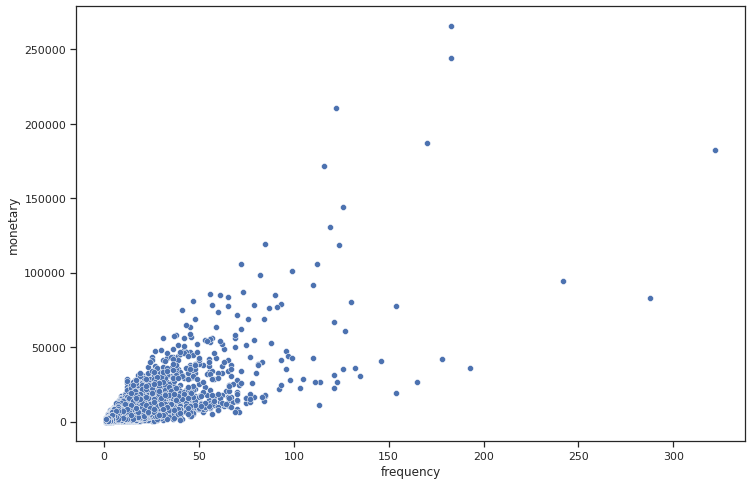

In [ ]:
sns.scatterplot(x='frequency', y='monetary', data=df_rfm)
plt.show()

Usunięcie wartości skrajnych - zaniechane - większa ilość braków danych w przypadku przewidywania

In [ ]:
# df_rfm = df_rfm.loc[(df_rfm['frequency'] < 200) & (df_rfm['monetary'] < 150000)]

# sns.scatterplot(x='frequency', y='monetary', data=df_rfm)
# plt.show()

Usunięcie kolumny `user_id`, żeby dodać ją później

In [ ]:
df_id = df_rfm["user_id"].copy()
df_rfm.drop("user_id", axis=1, inplace=True)
df_rfm

Standaryzacja

In [ ]:
standard_scaler = StandardScaler()
df_rfm_stan = pd.DataFrame(standard_scaler.fit_transform(df_rfm), columns=df_rfm.columns)

### Precomputed distance matrix check - sesja się kraszuje przy liczeniu macierzy

In [ ]:
X = df_rfm_stan.to_numpy()
distance_matrix = euclidean_distances(X)

In [ ]:
# silhouette score
kmeans_per_k = [KMeans(n_clusters=k).fit(df_rfm_stan)
                for k in range(2, 8)]
silhouette_scores = [silhouette_score(df_rfm_stan, model.labels_)
                     for model in kmeans_per_k]

### Wyznaczenie liczby `k`

In [ ]:
# silhouette score
kmeans_per_k = [KMeans(n_clusters=k).fit(df_rfm_stan)
                for k in range(2, 8)]
silhouette_scores = [silhouette_score(df_rfm_stan, model.labels_)
                     for model in kmeans_per_k]

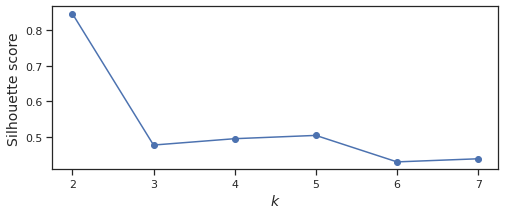

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 8), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.savefig("silhouette.png")
plt.show()

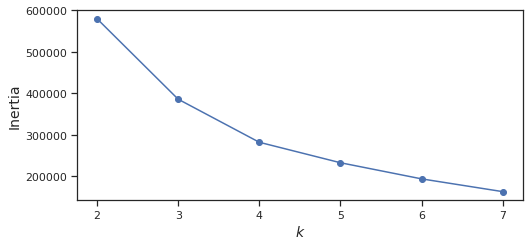

In [ ]:
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(2, 8), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.savefig("inertia.png")
plt.show()

### Model i wizualizacje dla 3 klastrów

In [ ]:
clusterNum = 3
k_means = KMeans(init="k-means++", n_clusters=clusterNum, n_init=30)
k_means.fit(df_rfm_stan)
labels = k_means.labels_
df_rfm["clusters_3"] = labels
df_rfm["user_id"]= df_id
# df_rfm = df_rfm.sort_values("clusters_3")
df_rfm

,recency,frequency,monetary,clusters_3
user_id,,,,
303160429,18,1,340.59,0
557057425,23,1,257.15,0
527688134,28,1,75.94,0
527688199,26,3,2684.53,0
557057258,21,1,250.93,0
...,...,...,...,...
530620607,5,1,131.02,2
530623236,6,1,44.25,2
530624671,6,1,131.51,2


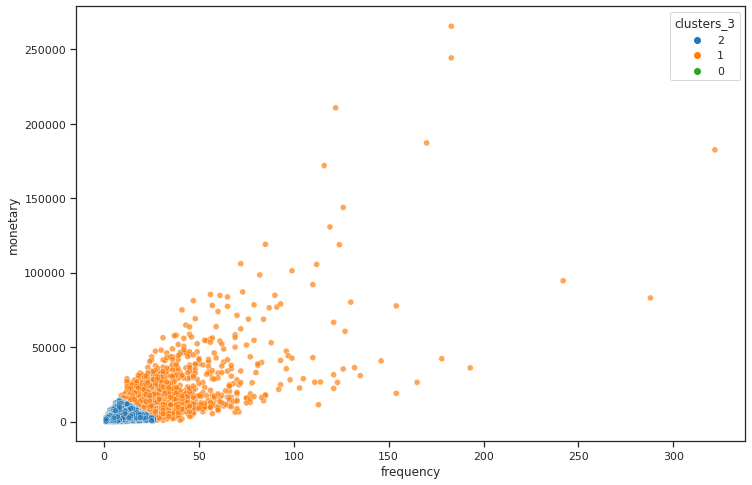

In [ ]:
df_rfm['clusters_3'] = df_rfm["clusters_3"].astype(str)
sns.scatterplot(x='frequency', y='monetary', data=df_rfm, hue='clusters_3', 
                hue_order=["2", "1", "0"], palette='tab10', alpha=0.7)
plt.show()

In [ ]:
df_rfm.groupby('clusters_3')['monetary'].describe()

,count,mean,std,min,25%,50%,75%,max
clusters_3,,,,,,,,
0,124515.0,481.908349,682.911036,0.88,131.760,251.49,553.405,14301.99
1,1875.0,17062.265701,17756.483444,864.49,8862.145,12979.18,18820.640,265569.52
2,137055.0,816.250209,1285.744294,0.88,160.620,353.37,923.560,13951.12


In [ ]:
df_rfm.groupby('clusters_3')['recency'].describe()

,count,mean,std,min,25%,50%,75%,max
clusters_3,,,,,,,,
0,124515.0,21.525318,4.842001,14.0,17.0,21.0,26.0,30.0
1,1875.0,4.793600,6.076756,0.0,0.0,2.0,7.0,30.0
2,137055.0,6.663872,4.205209,0.0,3.0,7.0,10.0,21.0


In [ ]:
df_rfm.groupby('clusters_3')['frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
clusters_3,,,,,,,,
0,124515.0,1.476264,1.124424,1.0,1.0,1.0,2.0,23.0
1,1875.0,30.036267,22.859736,9.0,18.0,24.0,34.0,322.0
2,137055.0,2.257284,2.411559,1.0,1.0,1.0,2.0,26.0


Wykres 3D

In [ ]:
# fig = px.scatter_3d(df_rfm, x='recency', y='frequency', z='monetary',
#                     color='clusters_3', opacity=0.7)
# fig.show()

In [ ]:
df_rfm.to_csv(r"/content/drive/MyDrive/Colab Notebooks/archive/2019-Oct_clean_with_segments.csv")

### Model i wizualizacje dla 4 klastrów

In [ ]:
clusterNum = 4
k_means = KMeans(init="k-means++", n_clusters=clusterNum, n_init=30)
k_means.fit(df_rfm_stan)
labels = k_means.labels_
df_rfm["clusters_4"] = labels
df_rfm = df_rfm.sort_values("clusters_4")

In [ ]:
df_rfm['clusters_4'] = df_rfm["clusters_4"].astype(str)
sns.scatterplot(x='frequency', y='monetary', data=df_rfm, hue='clusters_4', 
                hue_order=[ "3", "2", "1", "0"], palette='tab10')
plt.show()

In [ ]:
df_rfm.groupby('clusters_4')['monetary'].describe()

Wykres 3D

In [ ]:
# fig = px.scatter_3d(df_rfm, x='recency', y='frequency', z='monetary',
#                     color='clusters_4', opacity=0.7)
# fig.show()

In [ ]:
df_rfm.head()

In [ ]:
# df_rfm.to_csv(r"/content/drive/MyDrive/Colab Notebooks/archive/2019-Oct_clean_with_segments_4.csv")